# Implementazione di un algoritmo di previsione per serie storiche

Importiamo le librerie necessarie per svolgere il progetto

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Acquisiamo i dati in input

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/iantomasinicola/17dicembre/refs/heads/main/Dati%20input/Forecast_ets_example.csv",
            skiprows = 2,
            sep = ";" )

Visualizziamo le prime 5 righe

In [3]:
df.head(5)

,Date,Airport Passengers
0,2009-01-01,2644539.0
1,2009-02-01,2359800.0
2,2009-03-01,2925918.0
3,2009-04-01,3024973.0
4,2009-05-01,3177100.0


Modifichiamo in datetime il tipo della colonna Date, presente nel file di input nel formato YYYY-MM-DD 

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

Rappresentiamo la serie storica con un grafico a linee

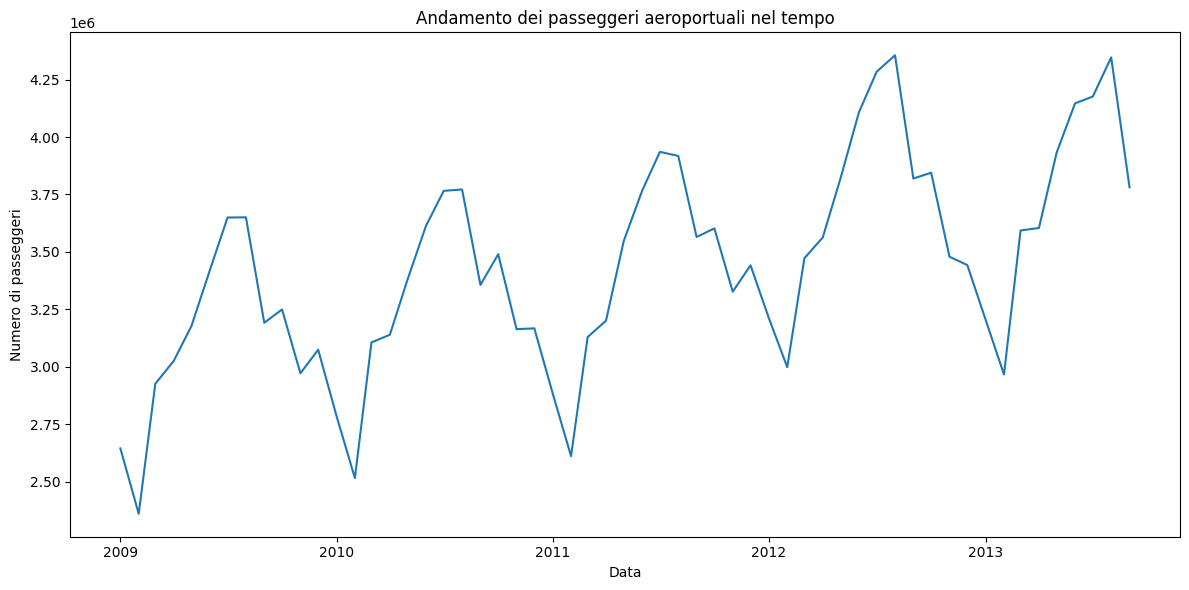

In [5]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df,
    x="Date",
    y="Airport Passengers"
)

plt.title("Andamento dei passeggeri aeroportuali nel tempo")
plt.xlabel("Data")
plt.ylabel("Numero di passeggeri")

plt.tight_layout()
plt.show()

Il grafico mostra l'andamento stagionale della serie storica. Applichiamo allora l'**algoritmo di decomposizione additiva della serie storiche**

Modifico preliminarmente le impostazioni di visualizzazione dei dati su pandas

In [6]:
pd.options.display.float_format = '{:.0f}'.format

Creo le medie mobili centrate

In [7]:
df["Media_mobile_centrata_step1"] = df["Airport Passengers"].rolling(window=12,center=True).mean()

df["Media_mobile_centrata_step2"] = df["Media_mobile_centrata_step1"].shift(-1)

df["Media_mobile_centrata"]=(df["Media_mobile_centrata_step1"]+df["Media_mobile_centrata_step2"])/2

df = df.drop("Media_mobile_centrata_step1", axis=1)

df = df.drop("Media_mobile_centrata_step2", axis=1)

df.head(12)

,Date,Airport Passengers,Media_mobile_centrata
0,2009-01-01,2644539,NaN
1,2009-02-01,2359800,NaN
2,2009-03-01,2925918,NaN
3,2009-04-01,3024973,NaN
4,2009-05-01,3177100,NaN
5,2009-06-01,3419595,NaN
6,2009-07-01,3649702,3117450
7,2009-08-01,3650668,3129804
8,2009-09-01,3191526,3143788
9,2009-10-01,3249428,3156043


Calcolo la componente di stagionalità e casualità

In [8]:
df["stagionalita_casualita"] = df["Airport Passengers"]-df["Media_mobile_centrata"]
df.head(12)

,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita
0,2009-01-01,2644539,NaN,NaN
1,2009-02-01,2359800,NaN,NaN
2,2009-03-01,2925918,NaN,NaN
3,2009-04-01,3024973,NaN,NaN
4,2009-05-01,3177100,NaN,NaN
5,2009-06-01,3419595,NaN,NaN
6,2009-07-01,3649702,3117450,532252
7,2009-08-01,3650668,3129804,520864
8,2009-09-01,3191526,3143788,47738
9,2009-10-01,3249428,3156043,93385


Creo una colonna che estrapola il mese della data

In [9]:
df["mese"]=df["Date"].dt.month
df.head(12)

,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita,mese
0,2009-01-01,2644539,NaN,NaN,1
1,2009-02-01,2359800,NaN,NaN,2
2,2009-03-01,2925918,NaN,NaN,3
3,2009-04-01,3024973,NaN,NaN,4
4,2009-05-01,3177100,NaN,NaN,5
5,2009-06-01,3419595,NaN,NaN,6
6,2009-07-01,3649702,3117450,532252,7
7,2009-08-01,3650668,3129804,520864,8
8,2009-09-01,3191526,3143788,47738,9
9,2009-10-01,3249428,3156043,93385,10


Calcolo le stagionalità

In [10]:
df_stagionalita = df.groupby(by="mese",
           as_index=False, 
           dropna=False)["stagionalita_casualita"].mean().rename(columns={"stagionalita_casualita":"stagionalita"})
df_stagionalita

,mese,stagionalita
0,1,-438632
1,2,-700095
2,3,-160906
3,4,-127126
4,5,139600
5,6,373322
6,7,529709
7,8,532818
8,9,78454
9,10,129151


Combino i due dataframe

In [11]:
df = pd.merge(df, df_stagionalita, on = "mese")
df.head(12)

,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita,mese,stagionalita
0,2009-01-01,2644539,NaN,NaN,1,-438632
1,2009-02-01,2359800,NaN,NaN,2,-700095
2,2009-03-01,2925918,NaN,NaN,3,-160906
3,2009-04-01,3024973,NaN,NaN,4,-127126
4,2009-05-01,3177100,NaN,NaN,5,139600
5,2009-06-01,3419595,NaN,NaN,6,373322
6,2009-07-01,3649702,3117450,532252,7,529709
7,2009-08-01,3650668,3129804,520864,8,532818
8,2009-09-01,3191526,3143788,47738,9,78454
9,2009-10-01,3249428,3156043,93385,10,129151


Calcoliamo i passeggeri destagionalizzati

In [12]:
df["passeggeri_destagionalizzati"] = df["Airport Passengers"]-df["stagionalita"]

Trasformo l'indice in una colonna

In [13]:
df = df.reset_index(names="Id")
df.head(12)

,Id,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita,mese,stagionalita,passeggeri_destagionalizzati
0,0,2009-01-01,2644539,NaN,NaN,1,-438632,3083171
1,1,2009-02-01,2359800,NaN,NaN,2,-700095,3059895
2,2,2009-03-01,2925918,NaN,NaN,3,-160906,3086824
3,3,2009-04-01,3024973,NaN,NaN,4,-127126,3152099
4,4,2009-05-01,3177100,NaN,NaN,5,139600,3037500
5,5,2009-06-01,3419595,NaN,NaN,6,373322,3046273
6,6,2009-07-01,3649702,3117450,532252,7,529709,3119993
7,7,2009-08-01,3650668,3129804,520864,8,532818,3117850
8,8,2009-09-01,3191526,3143788,47738,9,78454,3113072
9,9,2009-10-01,3249428,3156043,93385,10,129151,3120277


Calcolo la retta di regressione

In [14]:
m, q = np.polyfit(df.query("passeggeri_destagionalizzati.notna()")["Id"], 
                  df.query("passeggeri_destagionalizzati.notna()")["passeggeri_destagionalizzati"], 
                  1)
print(m,q)

14291.70413866918 3029099.320545136


Calcolo il trend

In [15]:
df["Trend"]= df["Id"]*m + q 
df.head(5)

,Id,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita,mese,stagionalita,passeggeri_destagionalizzati,Trend
0,0,2009-01-01,2644539,NaN,NaN,1,-438632,3083171,3029099
1,1,2009-02-01,2359800,NaN,NaN,2,-700095,3059895,3043391
2,2,2009-03-01,2925918,NaN,NaN,3,-160906,3086824,3057683
3,3,2009-04-01,3024973,NaN,NaN,4,-127126,3152099,3071974
4,4,2009-05-01,3177100,NaN,NaN,5,139600,3037500,3086266


Calcolo delle previsioni

In [16]:
df["Previsione"]=df["Trend"]+df["stagionalita"]
df.head(12)

,Id,Date,Airport Passengers,Media_mobile_centrata,stagionalita_casualita,mese,stagionalita,passeggeri_destagionalizzati,Trend,Previsione
0,0,2009-01-01,2644539,NaN,NaN,1,-438632,3083171,3029099,2590468
1,1,2009-02-01,2359800,NaN,NaN,2,-700095,3059895,3043391,2343296
2,2,2009-03-01,2925918,NaN,NaN,3,-160906,3086824,3057683,2896777
3,3,2009-04-01,3024973,NaN,NaN,4,-127126,3152099,3071974,2944848
4,4,2009-05-01,3177100,NaN,NaN,5,139600,3037500,3086266,3225866
5,5,2009-06-01,3419595,NaN,NaN,6,373322,3046273,3100558,3473880
6,6,2009-07-01,3649702,3117450,532252,7,529709,3119993,3114850,3644559
7,7,2009-08-01,3650668,3129804,520864,8,532818,3117850,3129141,3661959
8,8,2009-09-01,3191526,3143788,47738,9,78454,3113072,3143433,3221886
9,9,2009-10-01,3249428,3156043,93385,10,129151,3120277,3157725,3286876


Visualizzo le previsioni sui nuovi dati

In [17]:
df.query("`Airport Passengers`.isna()")[["Date","Previsione"]]

,Date,Previsione
57,2013-10-01,3972877
58,2013-11-01,3661743
59,2013-12-01,3706879
60,2014-01-01,3447970
61,2014-02-01,3200798
62,2014-03-01,3754279


Visualizziamo le previsioni con un colore differente

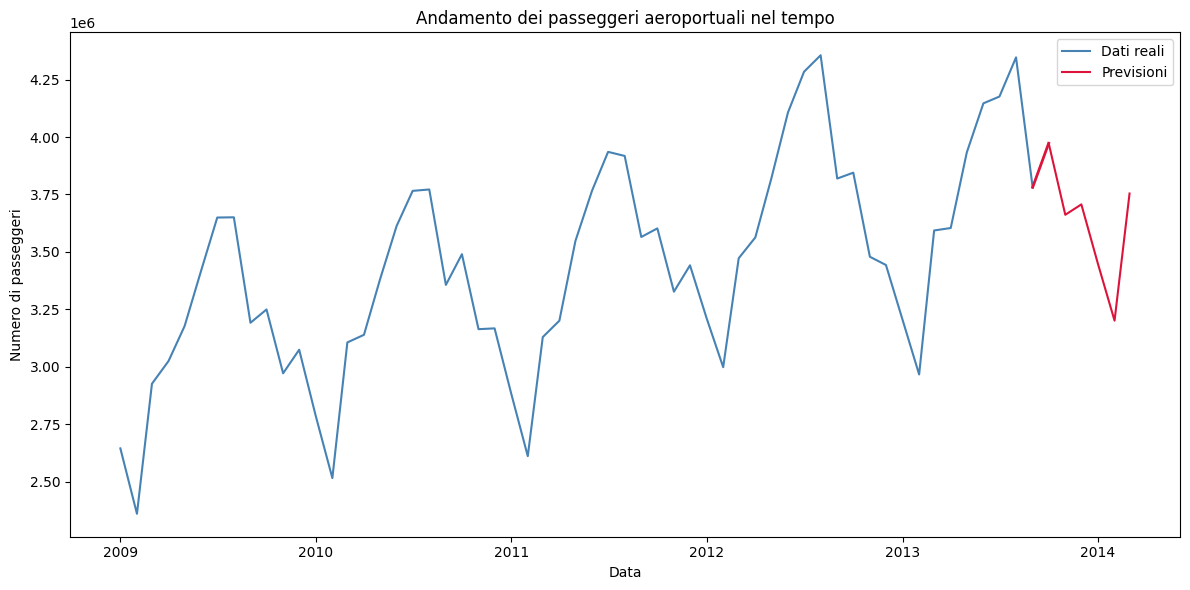

In [18]:
plt.figure(figsize=(12, 6))

#Grafico dati reali
sns.lineplot(
    data=df.query("`Airport Passengers`.notna()"),
    x="Date",
    y="Airport Passengers",
    color="steelblue",
    label="Dati reali"
)

#Grafico dati previsti
sns.lineplot(
    data=df.query("`Airport Passengers`.isna() "),
    x="Date",
    y="Previsione",
    color="crimson",
    label="Previsioni"
)

#Disegno giunzione
last_real = df.query("`Airport Passengers`.notna()").sort_values("Date").iloc[-1]
first_forecast = df.query("`Airport Passengers`.isna() ").sort_values("Date").iloc[0]
plt.plot(
    [last_real["Date"], first_forecast["Date"]],
    [last_real["Airport Passengers"], first_forecast["Previsione"]],
    color="crimson",
    linestyle="-",
    linewidth=2
)

plt.title("Andamento dei passeggeri aeroportuali nel tempo")
plt.xlabel("Data")
plt.ylabel("Numero di passeggeri")

plt.legend()
plt.tight_layout()
plt.show()

La previsione ottenuta rispetta il trend e l'andamento stagionale del fenomeno